<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D regression

##Imports

In [31]:
import numpy as np
from numpy import arange
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
from math import ceil
import keras
import tensorflow as tf
from tensorflow import norm
from tensorflow.math import reduce_mean, abs
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Input, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.initializers import RandomNormal, Zeros, Constant
from pylab import cm,imshow,contour,clabel,colorbar

In [32]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



##Preparing the data

###Defining the control points

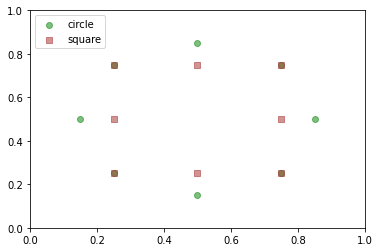

In [33]:
np.random.seed(1)
square = np.array([
                   [0.25,0.25],
                   [0.5,0.25],
                   [0.75,0.25],
                   [0.75,0.5],
                   [0.75,0.75],
                   [0.5,0.75],
                   [0.25,0.75],
                   [0.25,0.5]
                   ])
circle = np.array([
                   [0.25,0.25],
                   [0.5,0.15],
                   [0.75,0.25],
                   [0.85,0.5],
                   [0.75,0.75],
                   [0.5,0.85],
                   [0.25,0.75],
                   [0.15,0.5]
                   ])
plt.scatter(circle[:,0], circle[:,1], c='g', marker='o', label='circle', alpha=0.5)
plt.scatter(square[:,0], square[:,1], c='brown', marker='s', label='square', alpha=0.5)
plt.legend(loc='upper left')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

###Defining training data generator

In [34]:
class DataGenerator(Sequence):
  seed = 0
  def __init__(self, batchCount, batchSize, controlPoints):
    self.controlPoints = controlPoints
    self.batchCount = batchCount
    self.batchSize = batchSize
    self.seed = DataGenerator.seed
    DataGenerator.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return self.batchCount

  def __getitem__(self, idx):
    P = []
    for i in range(self.batchSize):
      p = self.randGen.random(2)
      P.append(p)
    return np.array(P), self.controlPoints

  #def on_epoch_end(self):
    #self.randGen = np.random.default_rng(seed=self.seed)

##Creating model

In [35]:
class CustomModel(Model):
  def __init__(self, *args, **kwargs):
    Model.__init__(self, *args, **kwargs)
    self.eikonalLambda = 0.1
    self.normalLambda = 1
    self.initialWeights = self.get_weights()

  def train_step(self, data):
    volumePoints, surfacePoints = data
    trainableVariables = self.trainable_variables
    with tf.GradientTape() as backpropTape:
      backpropTape.watch(trainableVariables)
      with tf.GradientTape() as eikonalTape:
        eikonalTape.watch(volumePoints)
        volumePred = self(volumePoints, training=True)
      volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
      eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')
      surfacePred = self(surfacePoints, training=True)
      surfaceAbs = abs(surfacePred)
      # surfaceAbs += self.normalLambda*norm(surfaceGrad-normals, 2, -1)
      surfaceLoss = reduce_mean(surfaceAbs)
      loss = surfaceLoss + self.eikonalLambda * eikonalLoss

    self.optimizer.minimize(loss, trainableVariables, tape=backpropTape)
    return {"loss": loss}
  
  def test_step(self, data):
    volumePoints, surfacePoints = data
    with tf.GradientTape() as eikonalTape:
      eikonalTape.watch(volumePoints)
      volumePred = self(volumePoints, training=True)
    volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
    eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')
    surfacePred = self(surfacePoints, training=True)
    surfaceLoss = reduce_mean(abs(surfacePred))
    loss = surfaceLoss + self.eikonalLambda * eikonalLoss
    return {"loss": loss}
  
  def reset(self):
    self.set_weights(self.initialWeights)

Model: "custom_model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 16)           48          input_4[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 16)           272         dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 2)            34          dense_13[0][0]                   
_____________________________________________________________________________________

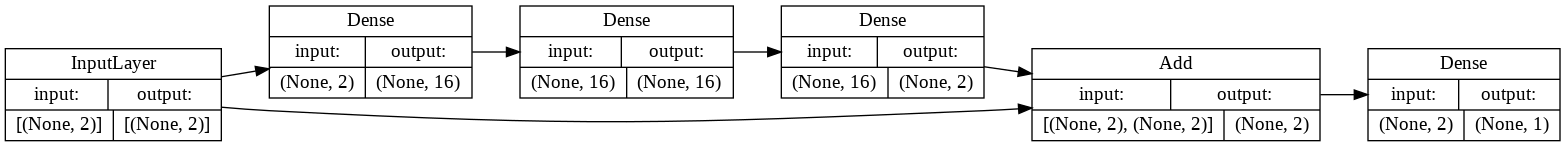

In [36]:
def SofterRelu(x):
  return tf.math.log(1 + tf.math.exp(100*x))/100
inputLayer = Input(shape=(2,))
hiddenLayer1 = Dense(16,
                     activation='softplus',
                     kernel_initializer= RandomNormal(stddev=np.sqrt(2)/np.sqrt(16)),
                     bias_initializer=Zeros())(inputLayer)
hiddenLayer2 = Dense(16,
                     activation='softplus',
                     kernel_initializer= RandomNormal(stddev=np.sqrt(2)/np.sqrt(16)),
                     bias_initializer=Zeros())(hiddenLayer1)
#dropout1 = Dropout(0.1)(hiddenLayer2)
hiddenLayer3 = Dense(2,
                     activation='softplus',
                     kernel_initializer= RandomNormal(mean=np.pi/np.sqrt(2), stddev=0.00001),
                     bias_initializer=Constant(-1))(hiddenLayer2)
skipLayer = Add()([hiddenLayer3, inputLayer])
outputLayer = Dense(1, activation='linear')(skipLayer)

model = CustomModel(inputs = inputLayer, outputs = outputLayer)
model.compile(optimizer = Adam(lr = 0.0015))
model.summary()
print(f'Trainable variables: {np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])}')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

##Feedback

In [37]:
def plot(model, controlPoints=None, plotSize='big'):
    sizeDict = {
        'big': ((13,10), 200, 0.05),
        'medium': ((8,5), 100, 0.1),
        'small': ((4,3), 40, 0.2),
    }
    figSize, resolution, lineDensity = sizeDict[plotSize]
    plt.figure(figsize=figSize)
    grid = np.empty((resolution*resolution,2))
    for y in range(resolution):
      for x in range(resolution):
        grid[y*resolution+x] = [x/resolution, y/resolution]
    prediction = np.array(model.predict(grid).reshape((resolution,resolution)))
    grid = []

    max = np.max(prediction)
    min = np.min(prediction)
    if (abs(min) > max):
      max = abs(min)
    im = imshow(prediction,
                cmap = sns.diverging_palette(220, 20, as_cmap=True),
                origin='lower',
                norm = colors.Normalize(vmin=-max, vmax=max))
    plt.axis('off')
    colorbar(im)
    cset = contour(prediction,arange(-0.6,0.6,lineDensity),linewidths=2,cmap='gray_r')
    clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
    if(controlPoints is not None):
      plot = sns.scatterplot(x=controlPoints[:,0]*resolution,
                      y=controlPoints[:,1]*resolution,
                      color = 'grey',
                      s = 80,
                      linewidth = 0)
    prediction = []
    plt.show()

class PlotCallback(Callback):
  def __init__(self, model, controlPoints, step=2):
    self.model = model
    self.controlPoints = controlPoints
    self.step = step
    self.plots = []

  def on_train_begin(self, logs=None):
    print('Initial weights')
    plot(self.model, controlPoints, plotSize='medium')

  def on_epoch_end(self, epoch, logs=None):
    if (epoch%self.step == 0):
      plot(self.model, controlPoints, plotSize='small')

##Train

Initial weights


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


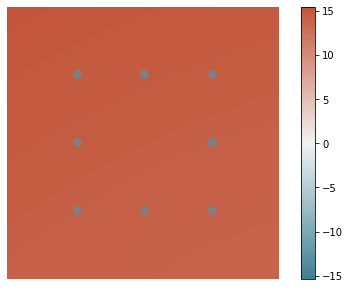

Epoch 1/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.1389


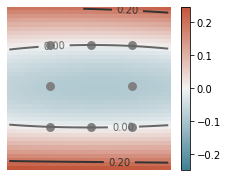

Epoch 2/10
10000/10000 [==============================] - 20s 2ms/step - loss: 0.0475


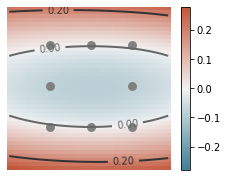

Epoch 3/10
10000/10000 [==============================] - 20s 2ms/step - loss: 0.0438


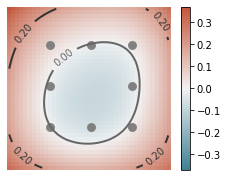

Epoch 4/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0362


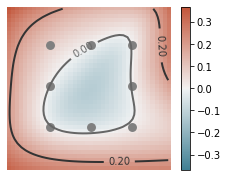

Epoch 5/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0227


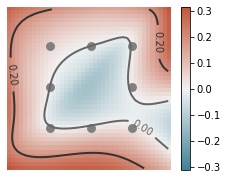

Epoch 6/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0192


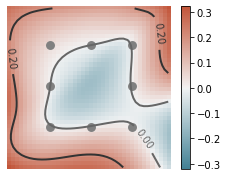

Epoch 7/10
10000/10000 [==============================] - 21s 2ms/step - loss: 0.0171


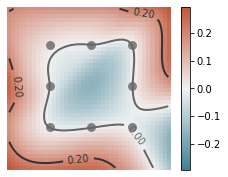

Epoch 8/10
10000/10000 [==============================] - 23s 2ms/step - loss: 0.0132


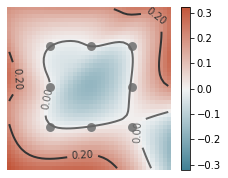

Epoch 9/10
10000/10000 [==============================] - 22s 2ms/step - loss: 0.0115


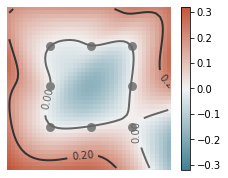

Epoch 10/10
10000/10000 [==============================] - 22s 2ms/step - loss: 0.0106


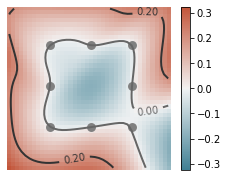

In [38]:
controlPoints = square
model.reset()
history = model.fit(DataGenerator(batchCount = 10000,
                                  batchSize = 128,
                                  controlPoints = controlPoints),
                    verbose = 1,
                    callbacks = [PlotCallback(model, controlPoints, 1)],
                    epochs = 10)

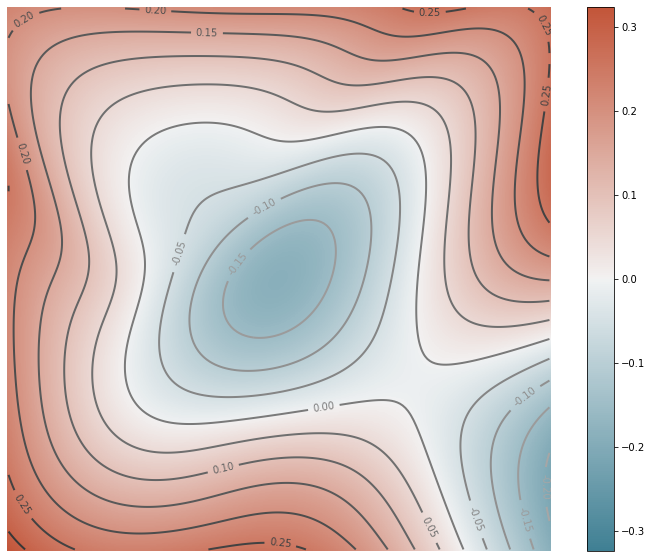

In [39]:
plot(model)

In [40]:
from tensorflow.python.framework import ops
from tensorflow.math import log, exp
beta = 100

def mySoftplus(x):
    return np.log(1 + np.exp(beta*x))/beta

npSoftplus = np.vectorize(mySoftplus)
npSoftplus32 = lambda x: npSoftplus(x).astype(np.float32)

def dMySoftplus(x):
  return 1/(1+np.exp(-beta*x))

npDSoftPlus = np.vectorize(dMySoftplus)

def tfDSoftplus(x, name=None):
  with tf.name_scope(name, "d_mySoftplus", [x]) as name:
    y = tf.py_func(npSoftplus32,
                   [x],
                   [tf.float32],
                   name=name,
                   stateful=False)
    return y[0]
def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    tf.RegisterGradient(rnd_name)(grad)
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)

def mySoftplusGrad(op, grad):
  x = op.inputs[0]
  return grad/(1+tf.math.exp(-beta*x))

def tfMySoftplus(x, name=None):
  with tf.name_scope("mySoftplus") as name:
        y = py_func(npSoftplus32,
                        [x],
                        [tf.float32],
                        name=name,
                        grad=mySoftplusGrad)
        return y[0]

with tf.compat.v1.Session() as sess:
  x = tf.constant(np.arange(-1, 1, 0.1, np.float32))
  y = tfMySoftplus(x)
  tf.initialize_all_variables().run()
  x = x.eval()
  y = y.eval()
  gr = tf.gradients(y, [x])[0].eval()
  plt.plot(x,y)
  plt.plot(x,gr)

KeyError: ignored